In [1]:
# Initialize GPU
import pyclesperanto_prototype as cle
import beetlesafari as bs
import numpy as np

cle.select_device('RTX')

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (1 refs)>

In [2]:
%gui qt

In [3]:
# convenience methods
def show(image, labels=False, title=None, use_napari=False):
    if len(image.shape) == 3:
        # print(image.shape)
        max_projection = cle.create([image.shape[1], image.shape[2]])
        cle.maximum_z_projection(image, max_projection)
        cle.imshow(cle.transpose_xy(max_projection), labels=labels, min_display_intensity=0)
    else:
        cle.imshow(cle.transpose_xy(image), labels=labels, min_display_intensity=0)    
    
    if use_napari:
        if labels:
            show.viewer.add_labels(cle.pull_zyx(image), name=title)
        else:
            show.viewer.add_image(cle.pull_zyx(image), name=title)

import napari

# create Qt GUI context
napari.gui_qt()        
show.viewer = napari.Viewer()

from napari_pyclesperanto_assistant import napari_plugin
napari_plugin(show.viewer)

------------------------
imread_raw took 0.031957149505615234
------------------------
imread_raw took 0.028957128524780273


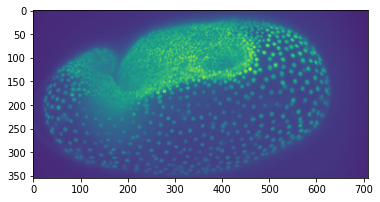

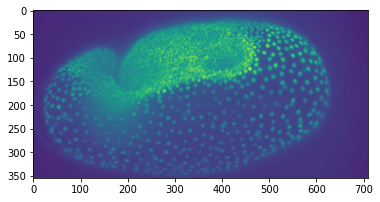

In [4]:
# Configure data source
path = 'C:/structure/data/2019-12-17-16-54-37-81-Lund_Tribolium_nGFP_TMR/stacks/C0opticsprefused/'
filename_1 = path + '001200.raw'
filename_2 = path + '001201.raw'
width = 512
height = 1024
depth = 71
voxel_size = [3, 0.6934, 0.6934]

# load and resample
def load_and_resample(filename, width, height, depth, voxel_size):
    img_arr = bs.imread_raw(filename, width, height, depth)
    buffer = cle.push_zyx(img_arr)
    return cle.resample(buffer, factor_x = voxel_size[2], factor_y = voxel_size[1], factor_z = voxel_size[0])

input_image = load_and_resample(filename_1, width, height, depth, voxel_size)
other_image = load_and_resample(filename_2, width, height, depth, voxel_size)
    
show(input_image, title="original", use_napari=True)
show(other_image, title="next timepoint", use_napari=True)

# Segmentation

subtract background took 0.15549015998840332
Num spots: 1789.0
spot detection took 0.12294912338256836
corrected number of spots 1789.0
cell segmentation took 0.12209057807922363


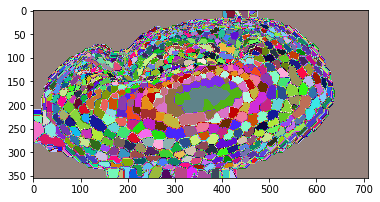

number of cells 1789.0
corrected number of cells 1784.0
next timepoint:
subtract background took 0.12923741340637207
Num spots: 1808.0
spot detection took 0.06407546997070312
corrected number of spots 1808.0
cell segmentation took 0.01817488670349121


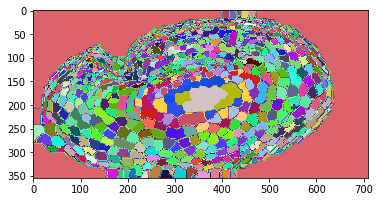

number of cells 1808.0
corrected number of cells 1804.0


In [5]:
def segmentation(image):
    background_subtracted = None
    background_subtracted = bs.background_subtraction(image, background_subtracted, 2, 7)
    # show(background_subtracted, title="background subtracted", use_napari=True)

    spots = cle.create_like(background_subtracted) 
    spots = bs.spot_detection(background_subtracted, spots, threshold=10)
    # show(spots, title="spots", use_napari=True)

    # temporary workaround; see https://github.com/clEsperanto/pyclesperanto_prototype/issues/63
    new_spots = cle.create_like(spots)
    cle.close_index_gaps_in_label_map(spots, new_spots)
    spots = new_spots
    print("corrected number of spots", cle.maximum_of_all_pixels(spots))

    cells = cle.create_like(spots)
    cells = bs.cell_segmentation(spots, cells, number_of_dilations=14, number_of_erosions=8)

    show(cells, title="cells", use_napari=True, labels=True)

    print("number of cells", cle.maximum_of_all_pixels(cells))

    # temporary workaround; see https://github.com/clEsperanto/pyclesperanto_prototype/issues/63
    new_cells = cle.create_like(cells)
    cle.close_index_gaps_in_label_map(cells, new_cells)
    cells = new_cells
    print("corrected number of cells", cle.maximum_of_all_pixels(cells))
    
    return cells

cells = segmentation(input_image)
print("=======================================\nnext timepoint:")
other_cells = segmentation(other_image)


In [6]:
stats = bs.collect_statistics(input_image, cells, other_image, other_cells)

(1785, 1785)


c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier9\_statistics_of_labelled_pixels.py:81: RuntimeWarning: invalid value encountered in float_scalars
  region_prop.mean_max_distance_to_centroid_ratio = region_prop.max_distance_to_centroid / region_prop.mean_distance_to_centroid


In [7]:
print(len(stats))


for key in stats:
    print(key, stats[key].shape)

19
nearest_neighbor_distance_n1 (1, 1785)
nearest_neighbor_distance_n4 (1, 1785)
nearest_neighbor_distance_n6 (1, 1785)
nearest_neighbor_distance_n8 (1, 1785)
nearest_neighbor_distance_n20 (1, 1785)
nearest_neighbor_distance (1, 1785)
touching_neighbor_count (1, 1785)
size (1, 1785)
mean_intensity (1, 1785)
standard_deviation_intensity (1, 1785)
minimum_intensity (1, 1785)
maximum_intensity (1, 1785)
mean_squared_error_intensity (1, 1785)
major_axis_length (1, 1785)
minor_axis_length (1, 1785)
sum_distance_to_centroid (1, 1785)
mean_distance_to_centroid (1, 1785)
mean_max_distance_to_centroid_ratio (1, 1785)
displacement_estimation (1, 1785)


In [8]:
neighborhoods = bs.neighbors(cells)
print(len(neighborhoods))

(1785, 1785)
3


In [10]:

element = stats['size']
print(cle.pull_zyx(element)[0])

data = bs.neighborized_feature_vectors(stats, neighborhoods)
print(data.shape)

[   0. 3578. 3089. ... 8486. 7314. 7980.]
key nearest_neighbor_distance_n1
n
n
n
key nearest_neighbor_distance_n4
n
n
n
key nearest_neighbor_distance_n6
n
n
n
key nearest_neighbor_distance_n8
n
n
n
key nearest_neighbor_distance_n20
n
n
n
key nearest_neighbor_distance
n
n
n
key touching_neighbor_count
n
n
n
key size
n


RuntimeError: clEnqueueReadBuffer failed: OUT_OF_RESOURCES

In [ ]:
def show_prediction(cells, prediction, name = "", use_napari=True):
    predicition_vector = cle.push_zyx(np.asarray([prediction]) + 1)

    # set background to 0
    cle.set_column(predicition_vector, 0, 0)
    print(predicition_vector)

    print(prediction)
    print(np.max(prediction))

    prediction_map = cle.replace_intensities(cells, predicition_vector)
    show(prediction_map, title="prediction " + name, use_napari=use_napari)
    
    mode_prediction = cle.mode_of_touching_neighbors(predicition_vector, neighbors_of_neighbors)
    prediction_map = cle.replace_intensities(cells, mode_prediction)
    show(prediction_map, title="prediction" + name, use_napari=use_napari)

## Gaussian mixture model

In [ ]:
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=num_classes, covariance_type='full')
clf.fit(data)
# print(clf.means_, clf.covariances_)

In [ ]:
# inspired by https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

gmm_prediction = clf.predict(data)

for i in range(clf.n_components):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(data[gmm_prediction == i, 0], data[gmm_prediction == i, 1], .8, color=color)

plt.xlabel("Nearest neighbor distance")
plt.ylabel("Number of touching neighbors")
plt.show()

show_prediction(cells, gmm_prediction, "Gaussian Mixture")

## K-means clustering

In [ ]:
# inspired by https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(data)

kmeans_prediction = kmeans.predict(data)

print(kmeans_prediction)

show_prediction(cells, kmeans_prediction, "K-means clustering")

## MeanShift
https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(data, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(data)
ms_prediction = ms.labels_

show_prediction(cells, ms_prediction, "MeanShift")

## AffinityPropagation
https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation().fit(data)

ap_prediction = ap.labels_

show_prediction(cells, ap_prediction, "AffinityPropagation")

## SpectralClustering

In [ ]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity='precomputed', n_init=100,
                         assign_labels='discretize')
sc_prediction = sc.fit_predict(cle.pull_zyx(touch_matrix))

show_prediction(cells, sc_prediction, "SpectralClustering")